In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# iterative k-means code from 'framework'
from sklearn.cluster import KMeans
def iterative_kmeans(X, z=1, s=3, n_clusters=8, **kwargs):
  '''
  Process X with KMeans yielding rows that appear in lower than m-z
   clusters, and recursively processing on higher than m+z clusters.
  '''
  O=[]
  n=0
  while len(X) != 0 and s > 0:
    km = KMeans(n_clusters=min(len(X), n_clusters), **kwargs)
    x = km.fit_predict(X)
    c = pd.value_counts(x).sort_values()
    ind = c[c <= z].index
    if len(ind) != 0:
        O+=[[X[x==i] for i in ind]]
    else:
        break
    X = X[np.in1d(x, c[c > z].index)]
    n+=1
    s-=1
  return (km, X, O)


def get_unique_df(df):
    df_u = df.drop_duplicates()
    df_u = df_u.sort_values(df.columns[0])
    df_u = df_u.reset_index(drop=True)
    return df_u

In [2]:

# Read the csv and start analysis
df = pd.read_csv('Diagnosis_dataset_all_selected_columns.csv')


C:\Users\GARAIS5\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:

# Creating pivot table with counts. This matrix will be used in iterative k-means.
df_1 = pd.pivot_table(df, index=['CCS Diagnosis Description'],values=['CCS Diagnosis Code'],
                      columns=['Discharge Year'],aggfunc='count').fillna(0).astype(int)


In [6]:
df_1 = df_1.drop(['E Codes: Unclassified'])
df_2 = df_1.transpose()
 
# transforming the feature space to - '% of change based on year 2009'
base = df_1[('CCS Diagnosis Code', 2009)]
for i, c in enumerate(df_1):
   df_1[c] = ((df_1[c] - base) / base * 100)

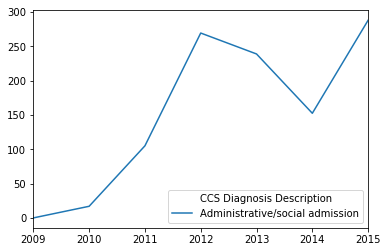

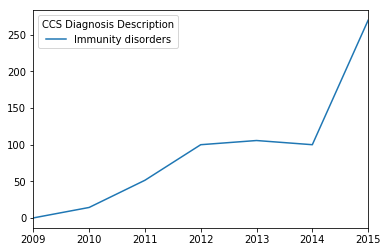

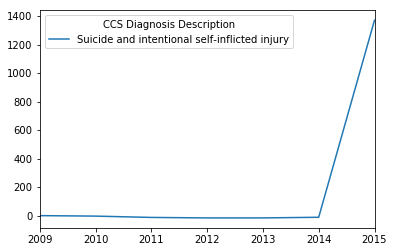

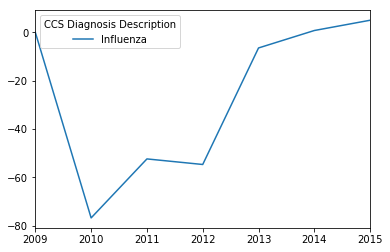

In [7]:
#  
# save the matrix for future reference    
df_1.to_csv('Percentage_of_increase_in_Count_of_Diagnosis_vs_Year.csv', encoding='utf-8', index=False)

#df_3 = df_1.transpose()  
# Run iterative k-means on the df   
km, X, O = iterative_kmeans(df_1, n_clusters=8, random_state=2012)

#Create a range for years to show in the plot
yr_bin = np.arange(2009, 2016, 1);

# Plot a basic graph for each outlier
%matplotlib inline
plt.clf()
for i, c in enumerate(O):
    for j, b in enumerate(c):      
        df_1.transpose().plot(y=b.index,x=yr_bin)   

In [26]:


#https://stackoverflow.com/questions/16992038/inline-labels-in-matplotlib
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.get_axes()
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = 100 + ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_axis_bgcolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].get_axes()
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

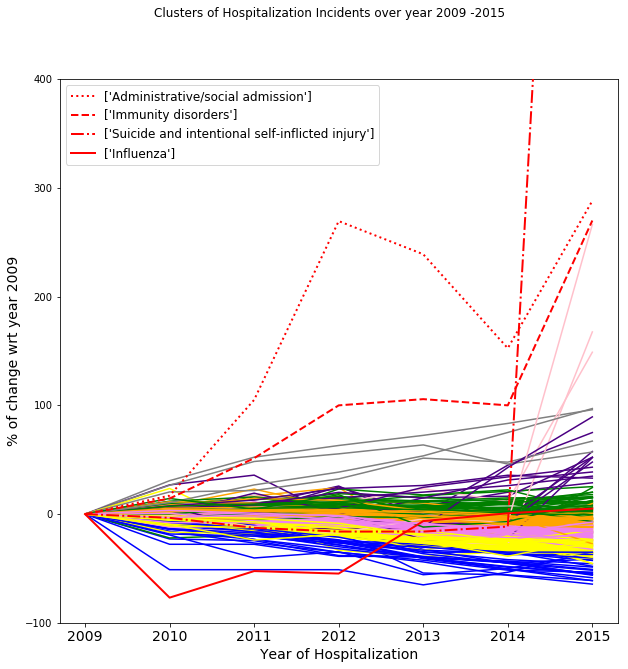

In [87]:

##Plot the results to show Outliers and to show clusters in a conbined plot

labels=km.labels_
colors = ["green","blue","grey","yellow","pink","indigo","orange","violet"]

import matplotlib.lines as mlines
plt.figure(figsize=(10,10))
plt.suptitle('Clusters of Hospitalization Incidents over year 2009 -2015')
plt.ylabel('% of change wrt year 2009')
plt.xlabel('Year of Hospitalization')


#legend_0 = mlines.Line2D([], [], color='red', ls='dotted',
#                          markersize=17, label='Outliers')
#plt.legend(handles=[legend_0])
'''
for j, m in enumerate(colors):
    plt.legend(handles=mlines.Line2D([], [], color=m, marker='_',
                          markersize=17, label='Cluster '+ str(j)))
'''

legend_1 = mlines.Line2D([], [], color='green', marker='_',
                          markersize=17, label='Cluster 1')
legend_2 = mlines.Line2D([], [], color='blue', marker='_',
                          markersize=17, label='Cluster 2')
legend_3 = mlines.Line2D([], [], color='grey', marker='_',
                          markersize=17, label='Cluster 3')
legend_4 = mlines.Line2D([], [], color='yellow', marker='_',
                          markersize=17, label='Cluster 4')
legend_5 = mlines.Line2D([], [], color='pink', marker='_',
                          markersize=17, label='Cluster 5')
legend_6 = mlines.Line2D([], [], color='indigo', marker='_',
                          markersize=17, label='Cluster 6')
legend_7 = mlines.Line2D([], [], color='orange', marker='_',
                          markersize=17, label='Cluster 7')
legend_8 = mlines.Line2D([], [], color='violet', marker='_',
                          markersize=17, label='Cluster 8')
#plt.legend(handles=[legend_0,legend_1,legend_2,legend_3,legend_4,legend_5,legend_6,legend_7,legend_8])
linestyles = [':', '--', '-.', '-']
legends = [0,1,2,3]
l=0
for i, c in enumerate(O):
    for j, b in enumerate(c):
        plt.plot(yr_bin,df_1.transpose()[b.index],':',color='red', linewidth=2,label=b.index.tolist(),linestyle=linestyles[l],zorder=10)
        l=l+1
plt.legend(loc='best')
#labelLines(plt.gca().get_lines(),align=True,fontsize=12, color='red')#
for i, c in enumerate(X.transpose()):
    plt.plot(yr_bin,X.transpose()[c],colors[labels[i]]) #color='grey')#
plt.ylim((-100,400))   

plt.show()



ValueError: x and y must have same first dimension, but have shapes (262,) and (7,)

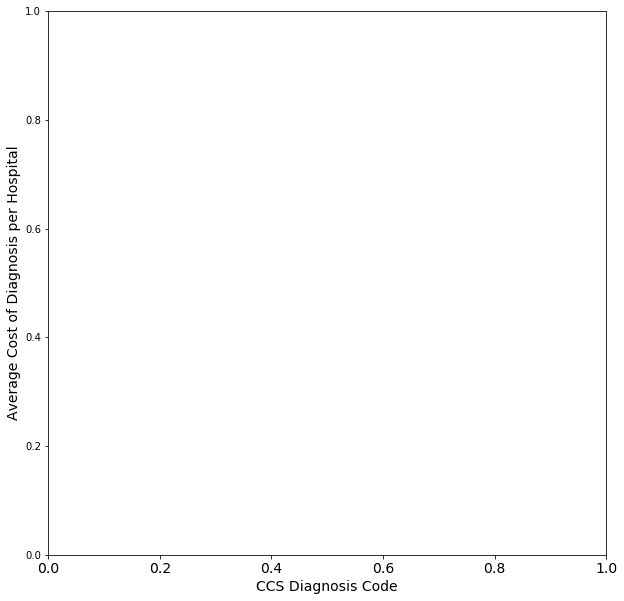

In [38]:

#labels=km.labels_
#colors = ["green","blue","grey","yellow","pink","indigo","orange","violet"]
plt.figure(figsize=(10,10))
plt.ylabel('Average Cost of Diagnosis per Hospital')
plt.xlabel('CCS Diagnosis Code')
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
for i, c in enumerate(X.transpose()):
    plt.plot(df_1.index,X.transpose()[c],linewidth=2,color= 'grey', alpha = 0.3, label = '')
for i, c in enumerate(O):
    for j, b in enumerate(c):      
        plt.plot(df_1.index,df_2.transpose()[b.index],color='blue',linewidth=1,label=b.index.tolist())
        #plt.plot(df_1.index,df_2.transpose()[b.index],':',color=colors[labels[i]],linewidth=2,label=b.index.tolist())
        plt.legend()
plt.show()
